In [1]:
# import psycopg2

import copy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import xgboost as xgb
# import lightgbm as lgb
# from catboost import CatBoostRegressor

import joblib
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import torch
from torch import nn
from torch.utils.data import Subset, DataLoader

from Dataset.Embedding_Dataset import Embedding_Dataset
from Model.Embedding import Embedding

from Dataset.Apartment_Complex_Dataset import Apartment_Complex_Dataset
from Model.LSTM import LSTM
from Model.GRU import GRU
from Model.Transformer import Transformer
from Model.Informer import Informer
from Model.Pyraformer import Pyraformer
from Model.N_BEATS import NBeats
from Model.NLinear import NLinear

from Dataset.District_Dataset import District_Dataset
from Model.LSTM_Attention import LSTMAttention
from Model.GRU_Attention import GRUAttention
from Model.Transformer_Attention import TransformerAttention
from Model.Informer_Attention import InformerAttention
from Model.Pyraformer_Attention import PyraformerAttention

from Filling_missing import *

SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# connection_info = "host=localhost dbname=postgres user=postgres password=hd219833 port=5432"
# conn = psycopg2.connect(connection_info)
# table_1_query = '''
#     SELECT * FROM building
#     '''
# table_2_query = '''
#     SELECT * FROM economy
#     '''
# table_3_query = '''
#     SELECT * FROM building_price
#     '''
# table_1 = pd.read_sql(table_1_query,conn) 
# table_2 = pd.read_sql(table_2_query,conn)
# table_3 = pd.read_sql(table_3_query,conn) 

table_1 = pd.read_csv('../데이터/Table/table_1.csv') 
table_2 = pd.read_csv('../데이터/Table/table_2.csv') 
table_3 = pd.read_csv('../데이터/Table/table_3.csv') 

### 결측치 채우기

In [2]:
old_and_new_dongs = {'용산동5가':'한강로동','한강로2가':'한강로동','창동':'창제동','돈암동':'정릉동','거여동':'위례동','문정동':'위례동','장지동':'위례동','문배동':'원효로동','산천동':'원효로동','신창동':'원효로동','원효로1가':'원효로동','화곡동':'우장산동','내발산동':'우장산동','영등포동8가':'영등포동','양평동3가':'양평동','안암동1가':'안암동','염리동':'아현동','성수동2가':'성수2가제2동','성수동1가':'성수1가제1동','중동':'성산동','노고산동':'서교동','신정동':'서강동','창전동':'서강동','삼선동4가':'삼선동','보문동3가':'보문동','동소문동7가':'동선동','당산동4가':'당산제2동','당산동5가':'당산제2동','당산동':'당산제2동','당산동3가':'당산제1동','당산동1가':'당산제1동','당산동2가':'당산제1동','본동':'노량진동','신수동':'노고산동','대흥동':'노고산동','금호동4가':'금호동','금호동2가':'금호동','충무로4가':'광희동','방화동':'공항동','도화동':'공덕동','신공덕동':'공덕동','일원동':'개포동'}
def change_dongs(location):
    parts = location.split(' ')
    if parts[2] in old_and_new_dongs:
        parts[2] = old_and_new_dongs[parts[2]]
    return ' '.join(parts)
table_1['location'] = table_1['location'].apply(change_dongs)

scaler = StandardScaler()
table_1[[cols for cols in table_1.columns if cols not in ['aid','location','name']]] = scaler.fit_transform(table_1[[cols for cols in table_1.columns if cols not in ['aid','location','name']]])
scaler.fit(table_2[[cols for cols in table_2.columns if cols not in ['did','year','month']]][:135])
table_2[[cols for cols in table_2.columns if cols not in ['did','year','month']]] = scaler.transform(table_2[[cols for cols in table_2.columns if cols not in ['did','year','month']]])

table_merge = pd.merge(table_1, table_3, how='left', on='aid')
table_merge = pd.merge(table_merge, table_2, how='left', on='did')
table_merge.sort_values(by='did',inplace=True)

input_values = table_merge[[cols for cols in table_merge.columns if cols not in ['aid','location','name','did','year','month','price']]].values
output_values = table_merge[['price']].values * 0.0001

### Embedding

In [2]:
epochs = 10000
lr = 1e-4
hidden_dim = 1024
sub = True # True
embedding_dim = 1024 # 1024
window_size = 12 # 12

In [7]:
# 파라미터
embedding_train_ratio = 0.7
embedding_val_ratio = 0.0
embedding_test_ratio = 0.3
embedding_batch = 64
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

embedding_lr = 0.00001
embedding_weight_decay = 0
embedding_batch = 128
embedding_epochs = 150
encoder_dim_1 = 128
encoder_dim_2 = 256
encoder_dim_3 = 512
embedding_dim = 1024
decoder_dim_1 = 512
decoder_dim_2 = 256
decoder_dim_3 = 128

embedding_window_size = 12 #????

=== Embedding 훈련 시작 ===
훈련용 파일 수: 8
테스트 파일: ../데이터/MissingValue\table_merge_2023.xlsx
테스트 데이터 로드: ../데이터/MissingValue\table_merge_2023.xlsx
테스트 데이터 크기: (2569, 19)
테스트 데이터 결측치: 0
✅ 테스트 데이터셋 크기: 2569

🔄 [1/8] bfill 방법으로 Embedding 훈련
파일: ../데이터/MissingValue\bfill_2021.xlsx
테스트 데이터 크기: (2569, 19)
테스트 데이터 결측치: 0
✅ 테스트 데이터셋 크기: 2569

🔄 [1/8] bfill 방법으로 Embedding 훈련
파일: ../데이터/MissingValue\bfill_2021.xlsx
훈련 데이터 크기: (25236, 19)
결측치 개수: 4713
✅ 데이터 준비 완료 - 훈련: 17665, 검증: 7571
훈련 데이터 크기: (25236, 19)
결측치 개수: 4713
✅ 데이터 준비 완료 - 훈련: 17665, 검증: 7571
🚀 bfill 훈련 시작...
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 Na

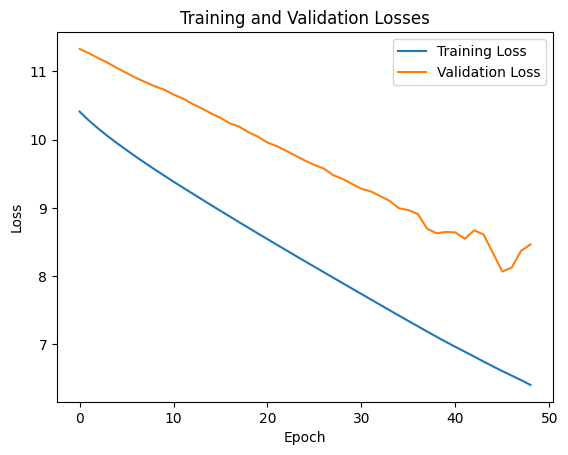


🔄 [5/8] nearest 방법으로 Embedding 훈련
파일: ../데이터/MissingValue\nearest_2021.xlsx
훈련 데이터 크기: (25236, 19)
결측치 개수: 1188
✅ 데이터 준비 완료 - 훈련: 17665, 검증: 7571
🚀 nearest 훈련 시작...
훈련 데이터 크기: (25236, 19)
결측치 개수: 1188
✅ 데이터 준비 완료 - 훈련: 17665, 검증: 7571
🚀 nearest 훈련 시작...
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1

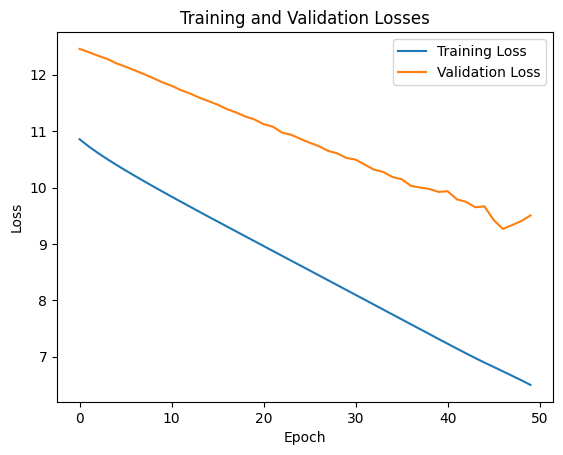


🔄 [6/8] polynomial 방법으로 Embedding 훈련
파일: ../데이터/MissingValue\polynomial_2021.xlsx
훈련 데이터 크기: (25236, 19)
결측치 개수: 1888
✅ 데이터 준비 완료 - 훈련: 17665, 검증: 7571
🚀 polynomial 훈련 시작...
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
훈련 데이터 크기: (25236, 19)
결측치 개수: 1888
✅ 데이터 준비 완료 - 훈련: 17665, 검증: 7571
🚀 polynomial 훈련 시작...
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너

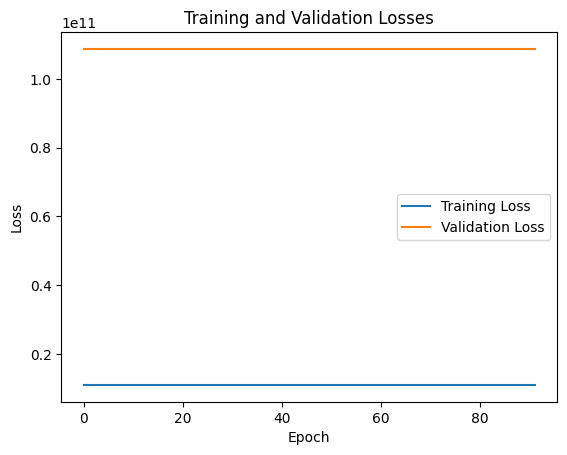


🔄 [7/8] spline 방법으로 Embedding 훈련
파일: ../데이터/MissingValue\spline_2021.xlsx
훈련 데이터 크기: (25236, 19)
결측치 개수: 1888
✅ 데이터 준비 완료 - 훈련: 17665, 검증: 7571
🚀 spline 훈련 시작...
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
훈련 데이터 크기: (25236, 19)
결측치 개수: 1888
✅ 데이터 준비 완료 - 훈련: 17665, 검증: 7571
🚀 spline 훈련 시작...
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련 타겟에 NaN/Inf 발견, 건너뜀
⚠️ Epoch 1: 훈련

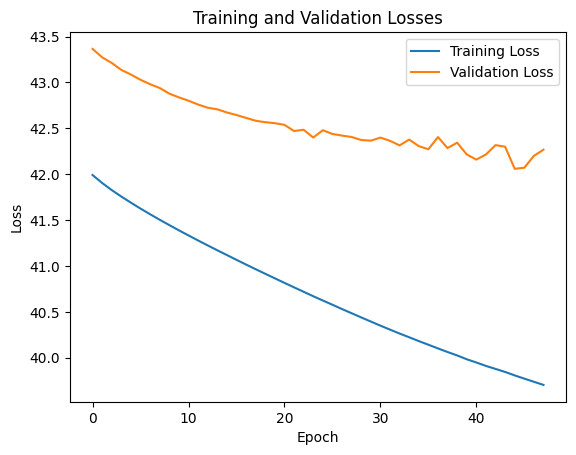


🔄 [8/8] table_merge 방법으로 Embedding 훈련
파일: ../데이터/MissingValue\table_merge_2021.xlsx
훈련 데이터 크기: (57800, 19)
결측치 개수: 0
✅ 데이터 준비 완료 - 훈련: 40460, 검증: 17340
🚀 table_merge 훈련 시작...
훈련 데이터 크기: (57800, 19)
결측치 개수: 0
✅ 데이터 준비 완료 - 훈련: 40460, 검증: 17340
🚀 table_merge 훈련 시작...
Epoch [1/150], Train Loss: 4.961905, Val Loss: 9.034721
Epoch [1/150], Train Loss: 4.961905, Val Loss: 9.034721
Epoch [10/150], Train Loss: 2.757991, Val Loss: 7.366921
Epoch [10/150], Train Loss: 2.757991, Val Loss: 7.366921
Epoch [20/150], Train Loss: 1.075812, Val Loss: 5.832965
Epoch [20/150], Train Loss: 1.075812, Val Loss: 5.832965
Epoch [30/150], Train Loss: 0.534790, Val Loss: 4.992555
Epoch [30/150], Train Loss: 0.534790, Val Loss: 4.992555
Epoch [40/150], Train Loss: 0.483615, Val Loss: 4.808389
Epoch [40/150], Train Loss: 0.483615, Val Loss: 4.808389
Epoch [50/150], Train Loss: 0.443681, Val Loss: 4.708311
Epoch [50/150], Train Loss: 0.443681, Val Loss: 4.708311
Epoch [60/150], Train Loss: 0.407097, Val Loss: 4.6

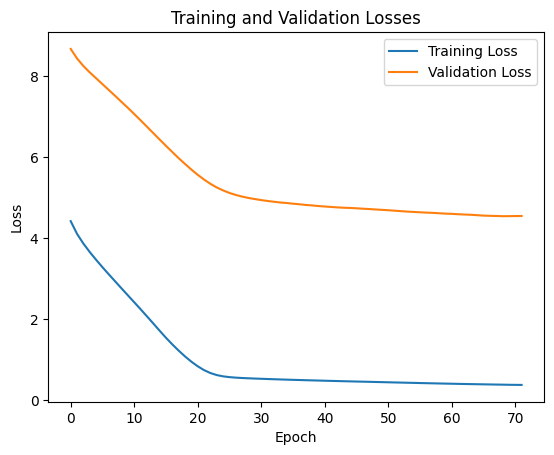


📋 전체 결과 정리

🏆 Embedding 결과 요약 (Val Loss 기준 정렬):
     Method  Best_Epoch  Best_Val_Loss  Test_Loss
table_merge          70   4.541987e+00   9.303299
     linear          47   8.066902e+00   6.658679
    nearest          48   9.266335e+00   7.490625
     spline          46   4.205887e+01  10.336520
 polynomial          90   1.087557e+11  13.948372

💾 결과 저장됨: ../데이터/MissingValue/embedding_results_summary.xlsx

🎯 최고 성능 방법: table_merge
   📈 Best Epoch: 70
   📊 Best Val Loss: 4.541987
   🎯 Test Loss: 9.303299

🎉 모든 Embedding 처리 완료!


In [24]:
# MissingValue 폴더의 모든 보간 데이터로 Embedding 훈련 및 평가
import os
import glob
import pandas as pd
import copy
import numpy as np

# 결과를 저장할 리스트
embedding_results = []

# MissingValue 폴더에서 훈련용 파일들 찾기 (2021 데이터)
missing_value_dir = "../데이터/MissingValue"
train_files = glob.glob(os.path.join(missing_value_dir, "*_2021.xlsx"))
test_file = os.path.join(missing_value_dir, "table_merge_2023.xlsx")

print(f"=== Embedding 훈련 시작 ===")
print(f"훈련용 파일 수: {len(train_files)}")
print(f"테스트 파일: {test_file}")

# 테스트 데이터 로드 (한 번만)
test_dataloader = None
if os.path.exists(test_file):
    print(f"테스트 데이터 로드: {test_file}")
    test_data = pd.read_excel(test_file)
    print(f"테스트 데이터 크기: {test_data.shape}")
    print(f"테스트 데이터 결측치: {test_data['price'].isna().sum()}")
    
    # 테스트 데이터 검증
    if test_data['price'].isna().all():
        print("⚠️ 테스트 데이터의 모든 price가 결측치입니다.")
        test_dataloader = None
    else:
        try:
            # 테스트 데이터셋 생성
            test_dataset = Embedding_Dataset(test_data, DEVICE)
            if len(test_dataset) > 0:
                test_dataloader = DataLoader(test_dataset, batch_size=embedding_batch, shuffle=False, drop_last=True)
                print(f"✅ 테스트 데이터셋 크기: {len(test_dataset)}")
            else:
                test_dataloader = None
                print("❌ 테스트 데이터셋이 비어있음")
        except Exception as e:
            print(f"❌ 테스트 데이터셋 생성 실패: {str(e)}")
            test_dataloader = None
else:
    print(f"❌ 테스트 파일이 없습니다: {test_file}")

# 각 훈련 파일에 대해 embedding 수행
for file_idx, train_file in enumerate(train_files):
    # 파일명에서 방법 추출
    method_name = os.path.basename(train_file).replace("_2021.xlsx", "")
    print(f"\n{'='*60}")
    print(f"🔄 [{file_idx+1}/{len(train_files)}] {method_name} 방법으로 Embedding 훈련")
    print(f"파일: {train_file}")
    print(f"{'='*60}")
    
    try:
        # 훈련 데이터 로드
        table_merge = pd.read_excel(train_file, engine='openpyxl')
        print(f"훈련 데이터 크기: {table_merge.shape}")
        print(f"결측치 개수: {table_merge['price'].isna().sum()}")
        
        # 데이터 검증
        if table_merge.empty:
            print(f"❌ {method_name}: 데이터가 비어있음")
            continue
            
        if table_merge['price'].isna().all():
            print(f"❌ {method_name}: 모든 price가 결측치")
            continue
        
        # 무한값이나 비정상적인 값 체크
        if np.isinf(table_merge['price']).any():
            print(f"⚠️ {method_name}: price에 무한값 발견, 제거 중...")
            table_merge = table_merge[~np.isinf(table_merge['price'])]
            
        if np.isnan(table_merge['price']).all():
            print(f"❌ {method_name}: 무한값 제거 후 모든 데이터가 결측치")
            continue
        
        # 데이터셋 생성
        dataset = Embedding_Dataset(table_merge, DEVICE)
        
        if len(dataset) == 0:
            print(f"❌ {method_name}: 데이터셋이 비어있음")
            continue
            
        dataset_length = len(dataset)
        split_point = int(embedding_train_ratio * len(dataset))
        
        if split_point == 0 or split_point == dataset_length:
            print(f"❌ {method_name}: 데이터 분할 오류 (split_point: {split_point}, total: {dataset_length})")
            continue
            
        train_indices = range(0, split_point)
        val_indices = range(split_point, dataset_length)

        train_dataset = Subset(dataset, train_indices)
        val_dataset = Subset(dataset, val_indices)

        train_dataloader = DataLoader(train_dataset, batch_size=embedding_batch, shuffle=False, drop_last=True)
        val_dataloader = DataLoader(val_dataset, batch_size=embedding_batch, shuffle=False, drop_last=True)
        
        if len(train_dataloader) == 0 or len(val_dataloader) == 0:
            print(f"❌ {method_name}: DataLoader가 비어있음 (train: {len(train_dataloader)}, val: {len(val_dataloader)})")
            continue
        
        print(f"✅ 데이터 준비 완료 - 훈련: {len(train_dataset)}, 검증: {len(val_dataset)}")
        
        # 모델 초기화
        model = Embedding(encoder_dim_1, encoder_dim_2, encoder_dim_3, embedding_dim, 
                         decoder_dim_1, decoder_dim_2, decoder_dim_3).to(DEVICE)
        criterion = RMSE()
        optimizer = torch.optim.Adam(model.parameters(), lr=embedding_lr, weight_decay=embedding_weight_decay)

        train_losses = []
        val_losses = []
        best_val_loss = float('inf')
        best_epoch = 0
        best_model_state = None
        consecutive_val_loss_increases = 0
        max_consecutive_val_loss_increases = 3

        print(f"🚀 {method_name} 훈련 시작...")
        
        for epoch in range(embedding_epochs):
            # 훈련 단계
            model.train()
            total_train_loss = 0
            train_batch_count = 0
            
            for data in train_dataloader:
                input = data[0].to(DEVICE)
                target = data[1].to(DEVICE)
                
                # 입력 데이터 검증
                if torch.isnan(input).any() or torch.isinf(input).any():
                    print(f"⚠️ Epoch {epoch+1}: 훈련 입력에 NaN/Inf 발견, 건너뜀")
                    continue
                if torch.isnan(target).any() or torch.isinf(target).any():
                    print(f"⚠️ Epoch {epoch+1}: 훈련 타겟에 NaN/Inf 발견, 건너뜀")
                    continue
                
                output = model(input).to(DEVICE)
                
                # 출력 검증
                if torch.isnan(output).any() or torch.isinf(output).any():
                    print(f"⚠️ Epoch {epoch+1}: 모델 출력에 NaN/Inf 발견")
                    break

                train_loss = criterion(output, target)
                
                # Loss 검증
                if torch.isnan(train_loss) or torch.isinf(train_loss):
                    print(f"⚠️ Epoch {epoch+1}: 훈련 loss가 NaN/Inf")
                    break
                
                total_train_loss += train_loss.item()
                train_batch_count += 1

                optimizer.zero_grad()
                train_loss.backward()
                
                # 그래디언트 클리핑
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                optimizer.step()

            if train_batch_count == 0:
                print(f"❌ Epoch {epoch+1}: 유효한 훈련 배치가 없음")
                break
                
            avg_train_loss = total_train_loss / train_batch_count
            
            if np.isnan(avg_train_loss) or np.isinf(avg_train_loss):
                print(f"❌ Epoch {epoch+1}: 평균 훈련 loss가 NaN/Inf ({avg_train_loss})")
                break
                
            train_losses.append(avg_train_loss)

            # 검증 단계
            model.eval()
            total_val_loss = 0
            val_batch_count = 0
            
            with torch.no_grad():
                for data in val_dataloader:
                    input = data[0].to(DEVICE)
                    target = data[1].to(DEVICE)
                    
                    # 입력 데이터 검증
                    if torch.isnan(input).any() or torch.isinf(input).any():
                        continue
                    if torch.isnan(target).any() or torch.isinf(target).any():
                        continue
                    
                    output = model(input).to(DEVICE)
                    
                    if torch.isnan(output).any() or torch.isinf(output).any():
                        continue

                    val_loss = criterion(output, target)
                    
                    if torch.isnan(val_loss) or torch.isinf(val_loss):
                        continue
                        
                    total_val_loss += val_loss.item()
                    val_batch_count += 1

            if val_batch_count == 0:
                print(f"❌ Epoch {epoch+1}: 유효한 검증 배치가 없음")
                break
                
            avg_val_loss = total_val_loss / val_batch_count
            
            if np.isnan(avg_val_loss) or np.isinf(avg_val_loss):
                print(f"❌ Epoch {epoch+1}: 평균 검증 loss가 NaN/Inf ({avg_val_loss})")
                break
                
            val_losses.append(avg_val_loss)
            
            # 최고 성능 기록
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_epoch = epoch + 1
                best_model_state = copy.deepcopy(model.state_dict())

            early_stop, consecutive_val_loss_increases = early_stops(val_losses, consecutive_val_loss_increases, max_consecutive_val_loss_increases)
            
            if early_stop:
                print(f'Epoch [{epoch+1}/{embedding_epochs}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')
                print(f'✋ Early Stop Triggered!')
                break

            if (epoch + 1) % 10 == 0 or epoch == 0:
                print(f'Epoch [{epoch+1}/{embedding_epochs}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')

        if not train_losses or not val_losses:
            print(f"❌ {method_name}: 훈련이 제대로 진행되지 않음")
            continue
            
        print(f"✅ {method_name} 훈련 완료!")
        print(f"   Best Epoch: {best_epoch}, Best Val Loss: {best_val_loss:.6f}")
        
        # 최고 모델로 테스트 데이터 평가
        avg_test_loss = float('nan')
        if test_dataloader is not None and best_model_state is not None:
            print(f"📊 {method_name} 테스트 데이터 평가 중...")
            
            try:
                # 최고 모델 로드
                model.load_state_dict(best_model_state)
                
                model.eval()
                total_test_loss = 0
                test_batch_count = 0
                
                with torch.no_grad():
                    for data in test_dataloader:
                        input = data[0].to(DEVICE)
                        target = data[1].to(DEVICE)
                        
                        if torch.isnan(input).any() or torch.isinf(input).any():
                            continue
                        if torch.isnan(target).any() or torch.isinf(target).any():
                            continue
                        
                        output = model(input).to(DEVICE)
                        
                        if torch.isnan(output).any() or torch.isinf(output).any():
                            continue

                        test_loss = criterion(output, target)
                        
                        if torch.isnan(test_loss) or torch.isinf(test_loss):
                            continue
                            
                        total_test_loss += test_loss.item()
                        test_batch_count += 1

                if test_batch_count > 0:
                    avg_test_loss = total_test_loss / test_batch_count
                    print(f"   Test Loss: {avg_test_loss:.6f}")
                else:
                    print(f"   ⚠️ 유효한 테스트 배치가 없음")
                    
            except Exception as e:
                print(f"   ❌ 테스트 평가 실패: {str(e)}")
        
        # 최고 모델 저장
        if best_model_state is not None:
            model_save_path = f'../데이터/Checkpoint/embedding/default/{method_name}_best_model.pth'
            torch.save(best_model_state, model_save_path)
            print(f"   💾 모델 저장: {model_save_path}")
        
        # 결과 저장
        result = {
            'Method': method_name,
            'File_Name': os.path.basename(train_file),
            'Best_Epoch': best_epoch,
            'Best_Val_Loss': round(best_val_loss, 6) if not (np.isnan(best_val_loss) or np.isinf(best_val_loss)) else 'Invalid',
            'Final_Train_Loss': round(train_losses[-1], 6) if train_losses and not (np.isnan(train_losses[-1]) or np.isinf(train_losses[-1])) else 'Invalid',
            'Test_Loss': round(avg_test_loss, 6) if not (pd.isna(avg_test_loss) or np.isinf(avg_test_loss)) else 'N/A',
            'Total_Epochs': len(train_losses),
            'Train_Data_Size': len(train_dataset),
            'Val_Data_Size': len(val_dataset),
            'Test_Data_Size': len(test_dataset) if test_dataloader is not None else 0
        }
        
        embedding_results.append(result)
        
        # 이 방법의 그래프 그리기
        if train_losses and val_losses:
            try:
                print(f"📊 {method_name} 학습 곡선 그래프 생성")
                plot_train_val_losses(train_losses, val_losses)
            except Exception as e:
                print(f"⚠️ 그래프 생성 실패: {str(e)}")
        
    except Exception as e:
        print(f"❌ {method_name} 처리 중 오류: {str(e)}")
        import traceback
        traceback.print_exc()
        
        # 오류 결과도 기록
        error_result = {
            'Method': method_name,
            'File_Name': os.path.basename(train_file),
            'Best_Epoch': 'Error',
            'Best_Val_Loss': 'Error', 
            'Final_Train_Loss': 'Error',
            'Test_Loss': 'Error',
            'Total_Epochs': 'Error',
            'Train_Data_Size': 'Error',
            'Val_Data_Size': 'Error',
            'Test_Data_Size': 'Error'
        }
        embedding_results.append(error_result)
            
        dataset_length = len(dataset)
        split_point = int(embedding_train_ratio * len(dataset))
        train_indices = range(0, split_point)
        val_indices = range(split_point, dataset_length)

        train_dataset = Subset(dataset, train_indices)
        val_dataset = Subset(dataset, val_indices)

        train_dataloader = DataLoader(train_dataset, batch_size=embedding_batch, shuffle=False, drop_last=True)
        val_dataloader = DataLoader(val_dataset, batch_size=embedding_batch, shuffle=False, drop_last=True)
        
        print(f"훈련 데이터: {len(train_dataset)}, 검증 데이터: {len(val_dataset)}")
        
        # 모델 초기화
        model = Embedding(encoder_dim_1, encoder_dim_2, encoder_dim_3, embedding_dim, 
                         decoder_dim_1, decoder_dim_2, decoder_dim_3).to(DEVICE)
        criterion = RMSE()
        optimizer = torch.optim.Adam(model.parameters(), lr=embedding_lr, weight_decay=embedding_weight_decay)

        train_losses = []
        val_losses = []
        best_val_loss = float('inf')
        best_epoch = 0
        best_model_state = None
        consecutive_val_loss_increases = 0
        max_consecutive_val_loss_increases = 3

        print(f"🚀 {method_name} 훈련 시작...")
        
        for epoch in range(embedding_epochs):
            model.train()
            total_train_loss = 0
            for data in train_dataloader:
                input = data[0].to(DEVICE)
                target = data[1].to(DEVICE)
                output = model(input).to(DEVICE)

                train_loss = criterion(output, target)
                total_train_loss += train_loss.item()

                optimizer.zero_grad()
                train_loss.backward()
                optimizer.step()

            avg_train_loss = total_train_loss / len(train_dataloader)
            train_losses.append(avg_train_loss)

            model.eval()
            total_val_loss = 0
            with torch.no_grad():
                for data in val_dataloader:
                    input = data[0].to(DEVICE)
                    target = data[1].to(DEVICE)
                    output = model(input).to(DEVICE)

                    val_loss = criterion(output, target)
                    total_val_loss += val_loss.item()

            avg_val_loss = total_val_loss / len(val_dataloader)
            val_losses.append(avg_val_loss)
            
            # 최고 성능 기록
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_epoch = epoch + 1
                best_model_state = copy.deepcopy(model.state_dict())

            early_stop, consecutive_val_loss_increases = early_stops(val_losses, consecutive_val_loss_increases, max_consecutive_val_loss_increases)
            
            if early_stop:
                print(f'Epoch [{epoch+1}/{embedding_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
                print(f'✋ Early Stop Triggered!')
                break

            if (epoch + 1) % 10 == 0 or epoch == 0:
                print(f'Epoch [{epoch+1}/{embedding_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

        print(f"✅ {method_name} 훈련 완료!")
        print(f"   Best Epoch: {best_epoch}, Best Val Loss: {best_val_loss:.6f}")
        
        # 최고 모델로 테스트 데이터 평가
        avg_test_loss = float('nan')
        if test_dataloader is not None and best_model_state is not None:
            print(f"📊 {method_name} 테스트 데이터 평가 중...")
            
            # 최고 모델 로드
            model.load_state_dict(best_model_state)
            
            model.eval()
            total_test_loss = 0
            with torch.no_grad():
                for data in test_dataloader:
                    input = data[0].to(DEVICE)
                    target = data[1].to(DEVICE)
                    output = model(input).to(DEVICE)

                    test_loss = criterion(output, target)
                    total_test_loss += test_loss.item()

            avg_test_loss = total_test_loss / len(test_dataloader)
            print(f"   Test Loss: {avg_test_loss:.6f}")
        
        # 최고 모델 저장
        if best_model_state is not None:
            model_save_path = f'../데이터/Checkpoint/embedding/default/{method_name}_best_model.pth'
            torch.save(best_model_state, model_save_path)
            print(f"   모델 저장: {model_save_path}")
        
        # 결과 저장
        result = {
            'Method': method_name,
            'File_Name': os.path.basename(train_file),
            'Best_Epoch': best_epoch,
            'Best_Val_Loss': round(best_val_loss, 6),
            'Final_Train_Loss': round(train_losses[-1], 6) if train_losses else float('nan'),
            'Test_Loss': round(avg_test_loss, 6) if not pd.isna(avg_test_loss) else 'N/A',
            'Total_Epochs': len(train_losses),
            'Train_Data_Size': len(train_dataset),
            'Val_Data_Size': len(val_dataset),
            'Test_Data_Size': len(test_dataset) if test_dataloader is not None else 0
        }
        
        embedding_results.append(result)
        
        # 이 방법의 그래프 그리기
        if train_losses and val_losses:
            print(f"📊 {method_name} 학습 곡선 그래프 생성")
            plot_train_val_losses(train_losses, val_losses)
        
    except Exception as e:
        print(f"❌ {method_name} 처리 중 오류: {str(e)}")
        import traceback
        traceback.print_exc()
        
        # 오류 결과도 기록
        error_result = {
            'Method': method_name,
            'File_Name': os.path.basename(train_file),
            'Best_Epoch': 'Error',
            'Best_Val_Loss': 'Error', 
            'Final_Train_Loss': 'Error',
            'Test_Loss': 'Error',
            'Total_Epochs': 'Error',
            'Train_Data_Size': 'Error',
            'Val_Data_Size': 'Error',
            'Test_Data_Size': 'Error'
        }
        embedding_results.append(error_result)

# 결과를 DataFrame으로 변환하고 저장
print(f"\n{'='*60}")
print(f"📋 전체 결과 정리")
print(f"{'='*60}")

if embedding_results:
    results_df = pd.DataFrame(embedding_results)
    
    # 숫자형 데이터만 정렬 (에러가 아닌 것들)
    numeric_results = results_df[results_df['Best_Val_Loss'] != 'Error'].copy()
    if not numeric_results.empty:
        numeric_results['Best_Val_Loss'] = pd.to_numeric(numeric_results['Best_Val_Loss'])
        numeric_results = numeric_results.sort_values('Best_Val_Loss').reset_index(drop=True)
        
        print("\n🏆 Embedding 결과 요약 (Val Loss 기준 정렬):")
        print(numeric_results[['Method', 'Best_Epoch', 'Best_Val_Loss', 'Test_Loss']].to_string(index=False))
        
        # 엑셀 파일로 저장
        results_file = "../데이터/MissingValue/embedding_results_summary.xlsx"
        results_df.to_excel(results_file, index=False, engine='openpyxl')
        print(f"\n💾 결과 저장됨: {results_file}")
        
        # 최고 성능 방법 출력
        best_method = numeric_results.iloc[0]
        print(f"\n🎯 최고 성능 방법: {best_method['Method']}")
        print(f"   📈 Best Epoch: {best_method['Best_Epoch']}")
        print(f"   📊 Best Val Loss: {best_method['Best_Val_Loss']:.6f}")
        print(f"   🎯 Test Loss: {best_method['Test_Loss']}")
        
    else:
        print("❌ 성공적으로 처리된 결과가 없습니다.")
        
else:
    print("❌ 처리할 파일이 없거나 모든 처리가 실패했습니다.")

print(f"\n{'='*60}")
print(f"🎉 모든 Embedding 처리 완료!")
print(f"{'='*60}")

## 간단한 Embedding 학습 및 테스트

In [28]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from Model.Embedding import Embedding
import warnings
warnings.filterwarnings('ignore')

# 데이터 로드
print("데이터 로드 중...")
train_data = pd.read_excel('../데이터/MissingValue/linear_2021.xlsx')
test_data = pd.read_excel('../데이터/MissingValue/table_merge_2023.xlsx')

print(f"학습 데이터: {train_data.shape[0]:,}개")
print(f"테스트 데이터: {test_data.shape[0]:,}개")

# 수치형 컬럼만 사용
numeric_cols = ['lat',
 'lng',
 'year_built',
 'education',
 'household',
 'parking',
 'complex_facility',
 'move_in_day',
 'subway_distance',
 'convenience_facility',
 'call_rate',
 'm2']
target_col = 'price'

# 데이터 준비
X_num = train_data[numeric_cols].fillna(0).astype(float)
y = train_data[target_col].fillna(train_data[target_col].median()).astype(float) * 0.0001
# 학습/검증 분할
X_num_train, X_num_val, y_train, y_val = train_test_split(
    X_num, y, test_size=0.2, random_state=42
)

# 하이퍼파라미터 설정
embedding_lr = 0.001
embedding_weight_decay = 1e-5

# 모델 초기화
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Embedding(encoder_dim_1, encoder_dim_2, encoder_dim_3, embedding_dim, 
                         decoder_dim_1, decoder_dim_2, decoder_dim_3).to(device)

# 손실 함수 및 옵티마이저
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=embedding_lr, weight_decay=embedding_weight_decay)


# 데이터를 텐서로 변환
X_num_train_tensor = torch.tensor(X_num_train.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1).to(device)

X_num_val_tensor = torch.tensor(X_num_val.values, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1).to(device)

# 학습
model.train()
for epoch in range(50):
    optimizer.zero_grad()
    outputs = model(X_num_train_tensor)  # Embedding 모델은 수치형 입력만 받음
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

# 학습 정확도
model.eval()
with torch.no_grad():
    train_pred = model(X_num_train_tensor).cpu().numpy()
    train_rmse = np.sqrt(mean_squared_error(y_train.values, train_pred))
    
    val_pred = model(X_num_val_tensor).cpu().numpy()
    val_rmse = np.sqrt(mean_squared_error(y_val.values, val_pred))

print(f"\n학습 RMSE: {train_rmse:.4f}")
print(f"검증 RMSE: {val_rmse:.4f}")

# 테스트 데이터 예측
if all(col in test_data.columns for col in numeric_cols + [target_col]):
    X_num_test = test_data[numeric_cols].fillna(0).astype(float)
    y_test = test_data[target_col].fillna(test_data[target_col].median()).astype(float)
    
    X_num_test_tensor = torch.tensor(X_num_test.values, dtype=torch.float32).to(device)
    
    with torch.no_grad():
        test_pred = model(X_num_test_tensor).cpu().numpy()
        test_rmse = np.sqrt(mean_squared_error(y_test.values, test_pred))
    
    print(f"테스트 RMSE: {test_rmse:.4f}")
else:
    print("테스트 데이터에 필요한 컬럼이 없음")

print("완료")

데이터 로드 중...
학습 데이터: 25,236개
테스트 데이터: 2,569개
학습 데이터: 25,236개
테스트 데이터: 2,569개

학습 RMSE: 2.7655
검증 RMSE: 2.8441
테스트 RMSE: 141299.5970
완료

학습 RMSE: 2.7655
검증 RMSE: 2.8441
테스트 RMSE: 141299.5970
완료


In [ ]:
'''
ffill : 141297.9237
linear : 141300.2213
polynomial : 141294.2213
GP : 141304.3529
우리 : 141299
'''


### 결측치 채우기

In [33]:
old_and_new_dongs = {'용산동5가':'한강로동','한강로2가':'한강로동','창동':'창제동','돈암동':'정릉동','거여동':'위례동','문정동':'위례동','장지동':'위례동','문배동':'원효로동','산천동':'원효로동','신창동':'원효로동','원효로1가':'원효로동','화곡동':'우장산동','내발산동':'우장산동','영등포동8가':'영등포동','양평동3가':'양평동','안암동1가':'안암동','염리동':'아현동','성수동2가':'성수2가제2동','성수동1가':'성수1가제1동','중동':'성산동','노고산동':'서교동','신정동':'서강동','창전동':'서강동','삼선동4가':'삼선동','보문동3가':'보문동','동소문동7가':'동선동','당산동4가':'당산제2동','당산동5가':'당산제2동','당산동':'당산제2동','당산동3가':'당산제1동','당산동1가':'당산제1동','당산동2가':'당산제1동','본동':'노량진동','신수동':'노고산동','대흥동':'노고산동','금호동4가':'금호동','금호동2가':'금호동','충무로4가':'광희동','방화동':'공항동','도화동':'공덕동','신공덕동':'공덕동','일원동':'개포동'}
def change_dongs(location):
    parts = location.split(' ')
    if parts[2] in old_and_new_dongs:
        parts[2] = old_and_new_dongs[parts[2]]
    return ' '.join(parts)
table_1['location'] = table_1['location'].apply(change_dongs)

scaler = StandardScaler()
table_1[[cols for cols in table_1.columns if cols not in ['aid','location','name']]] = scaler.fit_transform(table_1[[cols for cols in table_1.columns if cols not in ['aid','location','name']]])
scaler.fit(table_2[[cols for cols in table_2.columns if cols not in ['did','year','month']]][:135])
table_2[[cols for cols in table_2.columns if cols not in ['did','year','month']]] = scaler.transform(table_2[[cols for cols in table_2.columns if cols not in ['did','year','month']]])

table_merge = pd.merge(table_1, table_3, how='left', on='aid')
table_merge = pd.merge(table_merge, table_2, how='left', on='did')
table_merge.sort_values(by='did',inplace=True)

input_values = table_merge[[cols for cols in table_merge.columns if cols not in ['aid','location','name','did','year','month','price']]].values
output_values = table_merge[['price']].values * 0.0001

In [34]:
pip install torchdiffeq

   ---------------------------------------- 0.0/6.2 MB ? eta -:--:--
   ----------- ---------------------------- 1.8/6.2 MB 9.1 MB/s eta 0:00:01
   -------------------------------- ------- 5.0/6.2 MB 12.6 MB/s eta 0:00:01
   ---------------------------------------- 6.2/6.2 MB 11.9 MB/s eta 0:00:00

  Attempting uninstall: sympy

    Found existing installation: sympy 1.14.0

   ---------------------------------------- 0/2 [sympy]
   ---------------------------------------- 0/2 [sympy]
    Uninstalling sympy-1.14.0:
   ---------------------------------------- 0/2 [sympy]
   ---------------------------------------- 0/2 [sympy]
   ---------------------------------------- 0/2 [sympy]
   ---------------------------------------- 0/2 [sympy]
   ---------------------------------------- 0/2 [sympy]
   ---------------------------------------- 0/2 [sympy]
   ---------------------------------------- 0/2 [sympy]
   ---------------------------------------- 0/2 [sympy]
   ----------------------------

### Embedding

In [ ]:
epochs = 10000
lr = 1e-4
hidden_dim = 1024
sub = True # True
embedding_dim = 1024 # 1024
window_size = 12 # 12

In [ ]:
# 파라미터
embedding_train_ratio = 0.7
embedding_val_ratio = 0.0
embedding_test_ratio = 0.3
embedding_batch = 64
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

embedding_lr = 0.00001
embedding_weight_decay = 0
embedding_batch = 128
embedding_epochs = 150
encoder_dim_1 = 128
encoder_dim_2 = 256
encoder_dim_3 = 512
embedding_dim = 1024
decoder_dim_1 = 512
decoder_dim_2 = 256
decoder_dim_3 = 128

embedding_window_size = 12 #????

## 결측치 생성하기

In [35]:
## 1단계: 모든 aid에 2006~2021년, 1~12월 완전 데이터 생성

import pandas as pd
import numpy as np

# 데이터 로드
table_1 = pd.read_csv('../데이터/Table/table_1.csv')
table_2 = pd.read_csv('../데이터/Table/table_2.csv')
table_3 = pd.read_csv('../데이터/Table/table_3.csv')
table_merge_2021 = pd.read_excel('../데이터/MissingValue/table_merge_2021.xlsx')

# 모든 aid 가져오기
all_aids = table_1['aid'].unique()
years = range(2006, 2022)  # 2006~2021
months = range(1, 13)  # 1~12월

# 완전 데이터 생성
full_data = []

for aid in all_aids:
    # aid의 기본 정보 가져오기
    aid_info = table_1[table_1['aid'] == aid].iloc[0]
    # 해당 aid의 did 가져오기  
    did = table_3[table_3['aid'] == aid]['did'].iloc[0]
    
    for year in years:
        for month in months:
            # table_2에서 해당 연월의 경제 데이터 가져오기
            econ_data = table_2[(table_2['year'] == year) & (table_2['month'] == month)]
            
            if len(econ_data) > 0:
                call_rate = econ_data['call_rate'].iloc[0]
                m2 = econ_data['m2'].iloc[0]
            else:
                call_rate = np.nan
                m2 = np.nan
            
            # 기존 데이터에서 price 찾기
            existing_price = table_merge_2021[
                (table_merge_2021['aid'] == aid) & 
                (table_merge_2021['year'] == year) & 
                (table_merge_2021['month'] == month)
            ]
            
            price = existing_price['price'].iloc[0] if len(existing_price) > 0 else np.nan
            
            # 행 데이터 생성
            row_data = {
                'aid': aid,
                'lat': aid_info['lat'],
                'lng': aid_info['lng'], 
                'name': aid_info['name'],
                'location': aid_info['location'],
                'year_built': aid_info['year_built'],
                'education': aid_info['education'],
                'household': aid_info['household'],
                'parking': aid_info['parking'],
                'complex_facility': aid_info['complex_facility'],
                'move_in_day': aid_info['move_in_day'],
                'subway_distance': aid_info['subway_distance'],
                'convenience_facility': aid_info['convenience_facility'],
                'did': did,
                'year': year,
                'month': month,
                'call_rate': call_rate,
                'm2': m2,
                'price': price
            }
            
            full_data.append(row_data)

# 데이터프레임 생성
table_merge_2021_ver2 = pd.DataFrame(full_data)

print(f"전체 데이터 수: {len(table_merge_2021_ver2):,}")

# 저장
table_merge_2021_ver2.to_excel('../데이터/MissingValue/table_merge_2021_ver2.xlsx', index=False)
print("table_merge_2021_ver2.xlsx 저장 완료")

전체 데이터 수: 135,360
table_merge_2021_ver2.xlsx 저장 완료
table_merge_2021_ver2.xlsx 저장 완료


In [38]:
## 2단계: 다양한 방법으로 price 결측치 보간

from scipy.interpolate import interp1d
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import warnings
warnings.filterwarnings('ignore')

# 데이터 로드
data = pd.read_excel('../데이터/MissingValue/table_merge_2021_ver2.xlsx')
print(f"전체 데이터 수: {len(data):,}")

methods = ['ffill', 'linear', 'nearest', 'polynomial', 'spline', 'gp', 'node']

for method in methods:
    print(f"{method} 방법 처리 중...")
    result_data = data.copy()
    
    # aid별로 그룹화하여 처리
    for aid in data['aid'].unique():
        aid_mask = result_data['aid'] == aid
        aid_data = result_data[aid_mask].copy()
        aid_data = aid_data.sort_values(['year', 'month']).reset_index(drop=True)
        
        if method == 'ffill':
            # Forward fill
            aid_data['price'] = aid_data['price'].fillna(method='ffill')
            
        elif method == 'linear':
            # Linear interpolation
            aid_data['price'] = aid_data['price'].interpolate(method='linear')
            
        elif method == 'nearest':
            # Nearest interpolation
            aid_data['price'] = aid_data['price'].interpolate(method='nearest')
            
        elif method == 'polynomial':
            # Polynomial interpolation (order 2)
            try:
                aid_data['price'] = aid_data['price'].interpolate(method='polynomial', order=2)
            except:
                aid_data['price'] = aid_data['price'].interpolate(method='linear')
            
        elif method == 'spline':
            # Spline interpolation (order 2)
            try:
                aid_data['price'] = aid_data['price'].interpolate(method='spline', order=2)
            except:
                aid_data['price'] = aid_data['price'].interpolate(method='linear')
            
        elif method == 'gp':
            # Gaussian Process
            non_null_mask = aid_data['price'].notna()
            null_mask = aid_data['price'].isna()
            
            if non_null_mask.sum() > 1 and null_mask.sum() > 0:
                try:
                    X_train = aid_data.loc[non_null_mask, ['year', 'month']].values
                    y_train = aid_data.loc[non_null_mask, 'price'].values
                    X_pred = aid_data.loc[null_mask, ['year', 'month']].values
                    
                    gp = GaussianProcessRegressor(kernel=RBF(), alpha=1e-6)
                    gp.fit(X_train, y_train)
                    y_pred, _ = gp.predict(X_pred, return_std=True)
                    
                    aid_data.loc[null_mask, 'price'] = y_pred
                except:
                    aid_data['price'] = aid_data['price'].interpolate(method='linear')
                    
        elif method == 'node':
            # 앞뒤 값의 평균으로 채우기
            aid_data['price'] = aid_data['price'].interpolate(method='linear')
            # 맨 앞과 뒤의 NaN은 backward fill과 forward fill로 처리
            aid_data['price'] = aid_data['price'].fillna(method='bfill').fillna(method='ffill')
        
        # 결과 업데이트
        result_data.loc[aid_mask, 'price'] = aid_data['price'].values
    
    # 여전히 NaN인 값들은 전체 평균으로 채우기
    overall_mean = result_data['price'].mean()
    result_data['price'] = result_data['price'].fillna(overall_mean)
    
    # 저장
    filename = f'../데이터/MissingValue/{method}_2021.xlsx'
    result_data.to_excel(filename, index=False)
    print(f"{method}_2021.xlsx 저장 완료")

print("모든 방법 완료")

전체 데이터 수: 135,360
ffill 방법 처리 중...
ffill_2021.xlsx 저장 완료
linear 방법 처리 중...
ffill_2021.xlsx 저장 완료
linear 방법 처리 중...
linear_2021.xlsx 저장 완료
nearest 방법 처리 중...
linear_2021.xlsx 저장 완료
nearest 방법 처리 중...
nearest_2021.xlsx 저장 완료
polynomial 방법 처리 중...
nearest_2021.xlsx 저장 완료
polynomial 방법 처리 중...
polynomial_2021.xlsx 저장 완료
spline 방법 처리 중...
polynomial_2021.xlsx 저장 완료
spline 방법 처리 중...
spline_2021.xlsx 저장 완료
gp 방법 처리 중...
spline_2021.xlsx 저장 완료
gp 방법 처리 중...
gp_2021.xlsx 저장 완료
node 방법 처리 중...
gp_2021.xlsx 저장 완료
node 방법 처리 중...
node_2021.xlsx 저장 완료
모든 방법 완료
node_2021.xlsx 저장 완료
모든 방법 완료


## 간단한 Embedding 학습 및 테스트

In [42]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from Model.Embedding import Embedding
import warnings
warnings.filterwarnings('ignore')

# 데이터 로드
print("데이터 로드 중...")
test_data = pd.read_excel('../데이터/MissingValue/table_merge_2023.xlsx')

print(f"테스트 데이터: {test_data.shape[0]:,}개")

# 수치형 컬럼만 사용
numeric_cols = ['lat',
 'lng',
 'year_built',
 'education',
 'household',
 'parking',
 'complex_facility',
 'move_in_day',
 'subway_distance',
 'convenience_facility',
 'call_rate',
 'm2']
target_col = 'price'

# 데이터 준비

methods = ['ffill', 'linear', 'nearest', 'polynomial', 'spline', 'gp', 'node']
for method in methods:
    train_data = pd.read_excel('../데이터/MissingValue/{}_2021.xlsx'.format(method))
    X_num = train_data[numeric_cols].fillna(0).astype(float)
    y = train_data[target_col].fillna(train_data[target_col].median()).astype(float) * 0.0001
    # 학습/검증 분할
    X_num_train, X_num_val, y_train, y_val = train_test_split(
        X_num, y, test_size=0.2, random_state=42
    )

    # 하이퍼파라미터 설정
    embedding_lr = 0.001
    embedding_weight_decay = 1e-5

    # 모델 초기화
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = Embedding(encoder_dim_1, encoder_dim_2, encoder_dim_3, embedding_dim, 
                            decoder_dim_1, decoder_dim_2, decoder_dim_3).to(device)

    # 손실 함수 및 옵티마이저
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=embedding_lr, weight_decay=embedding_weight_decay)


    # 데이터를 텐서로 변환
    X_num_train_tensor = torch.tensor(X_num_train.values, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1).to(device)

    X_num_val_tensor = torch.tensor(X_num_val.values, dtype=torch.float32).to(device)
    y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1).to(device)

    # 학습
    model.train()
    for epoch in range(50):
        optimizer.zero_grad()
        outputs = model(X_num_train_tensor)  # Embedding 모델은 수치형 입력만 받음
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

    # 학습 정확도
    model.eval()
    with torch.no_grad():
        train_pred = model(X_num_train_tensor).cpu().numpy()
        train_rmse = np.sqrt(mean_squared_error(y_train.values, train_pred))
        
        val_pred = model(X_num_val_tensor).cpu().numpy()
        val_rmse = np.sqrt(mean_squared_error(y_val.values, val_pred))
    print(method, end=' ')
    print(f"\n학습 RMSE: {train_rmse:.4f}")
    print(method, end=' ')
    print(f"검증 RMSE: {val_rmse:.4f}")

    # 테스트 데이터 예측
    if all(col in test_data.columns for col in numeric_cols + [target_col]):
        X_num_test = test_data[numeric_cols].fillna(0).astype(float)
        y_test = test_data[target_col].fillna(test_data[target_col].median()).astype(float)
        
        X_num_test_tensor = torch.tensor(X_num_test.values, dtype=torch.float32).to(device)
        
        with torch.no_grad():
            test_pred = model(X_num_test_tensor).cpu().numpy()
            test_rmse = np.sqrt(mean_squared_error(y_test.values, test_pred))
        print(method, end=' ')
        print(f"테스트 RMSE: {test_rmse:.4f}")
    else:
        print("테스트 데이터에 필요한 컬럼이 없음")

print("완료")

데이터 로드 중...
테스트 데이터: 2,569개
테스트 데이터: 2,569개


KeyboardInterrupt: 

In [40]:
train_data = pd.read_excel('../데이터/MissingValue/table_merge_2021.xlsx')
X_num = train_data[numeric_cols].fillna(0).astype(float)
y = train_data[target_col].fillna(train_data[target_col].median()).astype(float) * 0.0001
# 학습/검증 분할
X_num_train, X_num_val, y_train, y_val = train_test_split(
    X_num, y, test_size=0.2, random_state=42
)

# 하이퍼파라미터 설정
embedding_lr = 0.001
embedding_weight_decay = 1e-5

# 모델 초기화
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Embedding(encoder_dim_1, encoder_dim_2, encoder_dim_3, embedding_dim, 
                        decoder_dim_1, decoder_dim_2, decoder_dim_3).to(device)

# 손실 함수 및 옵티마이저
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=embedding_lr, weight_decay=embedding_weight_decay)


# 데이터를 텐서로 변환
X_num_train_tensor = torch.tensor(X_num_train.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1).to(device)

X_num_val_tensor = torch.tensor(X_num_val.values, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1).to(device)

# 학습
model.train()
for epoch in range(50):
    optimizer.zero_grad()
    outputs = model(X_num_train_tensor)  # Embedding 모델은 수치형 입력만 받음
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

# 학습 정확도
model.eval()
with torch.no_grad():
    train_pred = model(X_num_train_tensor).cpu().numpy()
    train_rmse = np.sqrt(mean_squared_error(y_train.values, train_pred))
    
    val_pred = model(X_num_val_tensor).cpu().numpy()
    val_rmse = np.sqrt(mean_squared_error(y_val.values, val_pred))
print(method, end=' ')
print(f"\n학습 RMSE: {train_rmse:.4f}")
print(method, end=' ')
print(f"검증 RMSE: {val_rmse:.4f}")

# 테스트 데이터 예측
if all(col in test_data.columns for col in numeric_cols + [target_col]):
    X_num_test = test_data[numeric_cols].fillna(0).astype(float)
    y_test = test_data[target_col].fillna(test_data[target_col].median()).astype(float)
    
    X_num_test_tensor = torch.tensor(X_num_test.values, dtype=torch.float32).to(device)
    
    with torch.no_grad():
        test_pred = model(X_num_test_tensor).cpu().numpy()
        test_rmse = np.sqrt(mean_squared_error(y_test.values, test_pred))
    print(method, end=' ')
    print(f"테스트 RMSE: {test_rmse:.4f}")
else:
    print("테스트 데이터에 필요한 컬럼이 없음")

node 
학습 RMSE: 0.8498
node 검증 RMSE: 0.8867
node 테스트 RMSE: 141298.3608


In [41]:
'''
ffill : 141300.4800
linear : 141300.5779
nearest : 141304.2038
polynomial : 141303.5074
spiine : 141304.7111
GP : 141308.2727
node : 141297.1721
우리 : 141298.3608
'''

'\nffill : 141300.4800\nlinear : 141300.5779\nnearest : 141304.2038\npolynomial : 141303.5074\nspiine : 141304.7111\nGP : 141308.2727\nnode : 141297.1721\n우리 : 141298.3608\n'

## 구 최대개수와 최소개수 비교하기

In [43]:
## table_merge_2023 동 분석

# table_merge_2023 데이터 로드
table_merge_2023 = pd.read_excel('../데이터/MissingValue/table_merge_2023.xlsx')

# location을 split해서 동 정보 추출 (2번째 인덱스)
table_merge_2023['dong'] = table_merge_2023['location'].str.split().str[2]

print(f"전체 데이터 수: {len(table_merge_2023):,}")
print(f"고유 동 개수: {table_merge_2023['dong'].nunique()}")

# 동별 개수 계산
dong_counts = table_merge_2023['dong'].value_counts()

print(f"\n가장 많은 동: {dong_counts.index[0]} ({dong_counts.iloc[0]:,}개)")
print(f"가장 적은 동: {dong_counts.index[-1]} ({dong_counts.iloc[-1]:,}개)")

전체 데이터 수: 2,569
고유 동 개수: 114

가장 많은 동: 상계동 (84개)
가장 적은 동: 수송동 (1개)


### 데이터 개수가 얼마나 영향 미치는지 확인하기

In [45]:
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

lr = 1e-4
batch = 64
hidden_dim = 1024
embedding_dim = 1024
sub = True
embedding_dim = 1024
window_size = 12

In [55]:
table_1 = pd.read_csv('../데이터/Table/table_1.csv') 
table_2 = pd.read_csv('../데이터/Table/table_2.csv') 
table_3 = pd.read_csv('../데이터/Table/table_3.csv') 

In [50]:
table_1['dong'] = table_1['location'].str.split().str[2]
table_1_sang = table_1[table_1['dong'] == '상계동']
table_1_su = table_1[table_1['dong'] == '수송동']

In [58]:
table_1.head()

,aid,location,name,lat,lng,year_built,education,household,parking,complex_facility,move_in_day,subway_distance,convenience_facility
0,0,서울특별시 강남구 개포동 개포로 311,"우성9차아파트901동,902동",37.484802,127.057178,1991,3,233,1,0,11687,4,6
1,1,서울특별시 강남구 개포동 개포로 409,현대아파트3,37.487899,127.060924,1986,4,198,1,0,13454,2,7
2,2,서울특별시 강남구 개포동 언주로 110,경남1,37.484387,127.054267,1984,7,678,1,3,14543,8,10
3,3,서울특별시 강남구 개포동 언주로 110,경남2차,37.484387,127.054267,1984,7,678,1,3,14543,8,10
4,4,서울특별시 강남구 논현동 강남대로146길 28,신동아(22),37.514697,127.022742,1997,4,644,2,7,9314,4,1


In [51]:
embedding_model = torch.load("../데이터/Checkpoint/embedding/default/embedding_lr_0.0001_batch_64_sub_True_emb_1024_ws_12_epochs_13.pth", map_location=DEVICE, weights_only=False)
dataset = District_Dataset(embedding_model, table_1_sang, table_2, table_3, embedding_dim, window_size, sub, DEVICE)
dataset_length = len(dataset)
train_size = int(train_ratio * dataset_length)
# train_indices = range(0, train_size)
val_size = int(val_ratio * dataset_length)
# val_indices = range(train_size, train_size + val_size)
test_size = int(test_ratio * dataset_length)
test_indices = range(train_size + val_size, dataset_length)
# train_dataset = Subset(dataset, train_indices)
# val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)
# train_dataloader = DataLoader(train_dataset, batch_size=batch, shuffle=False, drop_last=True)
# val_dataloader = DataLoader(val_dataset, batch_size=batch, shuffle=False, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch, shuffle=False, drop_last=True)

ValueError: could not convert string to float: '상계동'

In [47]:
model_name = 'transformer_attention'

In [48]:
if model_name == "lstm":
    model = torch.load("../데이터/Checkpoint/lstm/lstm_lr_0.0001_batch_64_hid_1024_sub_True_emb_1024_ws_12_epochs_17.pth", map_location=DEVICE, weights_only=False)
elif model_name == "gru":
    model = torch.load("../데이터/Checkpoint/gru/gru_lr_0.0001_batch_64_hid_1024_sub_True_emb_1024_ws_12_epochs_15.pth", map_location=DEVICE, weights_only=False)
elif model_name == "transformer":
    model = torch.load("../데이터/Checkpoint/transformer/transformer_lr_0.0001_batch_64_sub_True_emb_1024_ws_12_epochs_26.pth", map_location=DEVICE, weights_only=False)
elif model_name == "informer":
    model = torch.load(f'../데이터/Checkpoint/informer/informer_lr_0.0001_batch_64_sub_True_emb_1024_ws_12_epochs_27.pth', map_location=DEVICE, weights_only=False)
elif model_name == "pyraformer":
    model = torch.load(f'../데이터/Checkpoint/pyraformer/pyraformer_lr_0.0001_batch_64_sub_True_emb_1024_ws_12_epochs_11.pth', map_location=DEVICE, weights_only=False)
elif model_name == "nbeats":
    model = torch.load(f'../데이터/Checkpoint/n_beats/n_beats_lr_0.0001_batch_64_sub_True_emb_1024_ws_12_epochs_25.pth', map_location=DEVICE, weights_only=False)
elif model_name == "nlinear":
    model = torch.load(f'../데이터/Checkpoint/nlinear/nlinear_lr_0.0001_batch_64_sub_True_emb_1024_ws_12_epochs_29.pth', map_location=DEVICE, weights_only=False)
elif model_name == "lstm_attention":
    model = torch.load("../데이터/Checkpoint/lstm_attention/lstm_attention_lr_0.0001_batch_64_sub_True_emb_1024_ws_12_epochs_16.pth", map_location=DEVICE, weights_only=False)
elif model_name == "gru_attention":
    model = torch.load("../데이터/Checkpoint/gru/attention/gru_attention_lr_0.0001_batch_64_sub_True_emb_1024_ws_12_epochs_4.pth", map_location=DEVICE, weights_only=False)
elif model_name == "transformer_attention":
    model = torch.load("../데이터/Checkpoint/transformer_attention/transformer_attention_lr_0.0001_batch_64_sub_True_emb_1024_ws_12_epochs_37.pth", map_location=DEVICE, weights_only=False)
elif model_name == "informer_attention":
    model = torch.load("../데이터/Checkpoint/informer_attention/informer_attention_lr_0.0001_batch_64_sub_True_emb_1024_ws_12_epochs_5.pth", map_location=DEVICE, weights_only=False)
elif model_name == "pyraformer_attention":
    model = torch.load("../데이터/Checkpoint/pyraformer_attention/pyraformer_attention_lr_0.0001_batch_64_sub_True_emb_1024_ws_12_epochs_X.pth", map_location=DEVICE, weights_only=False)

In [ ]:
import pickle

model.eval()
test_rmses = []
test_mses = []
test_maes = []
test_r2s = []

test_outputs = []
test_trgs = []

with torch.no_grad():
    for batch_idx, data in enumerate(test_dataloader):
        batch_size = len(data[0])  # 배치 내 동의 개수
        
        # 배치 내 모든 동에 대해 처리
        for district_idx in range(batch_size):
            src = data[0][district_idx].to(DEVICE)  # shape: [max_apartments, window_size, embedding_dim]
            max_len = data[1][district_idx].to(DEVICE)
            try:
                anw = torch.nonzero(data[2][district_idx]).squeeze()
                if anw.dim() == 0:  # 단일 원소인 경우
                    anw = anw.unsqueeze(0)
            except:
                continue
            trg = data[3][district_idx].to(DEVICE)

            # 해당 동의 모든 아파트 단지에 대해 예측
            for index in anw:
                # 모델별 처리
                if model_name == "lstm":
                    apartment_src = src[index].unsqueeze(0)  # [1, window_size, embedding_dim]
                    output, _, _ = model(apartment_src)
                elif model_name == "gru":
                    apartment_src = src[index].unsqueeze(0)  # [1, window_size, embedding_dim]
                    output, _ = model(apartment_src)
                elif model_name == "transformer":
                    apartment_src = src[index].unsqueeze(0)  # [1, window_size, embedding_dim]
                    src_mask = model.generate_square_subsequent_mask(apartment_src.shape[1]).to(apartment_src.device)
                    output, _ = model(apartment_src, src_mask)
                elif model_name == "informer":
                    apartment_src = src[index].unsqueeze(0)  # [1, window_size, embedding_dim]
                    output, _ = model(apartment_src)
                elif model_name == "pyraformer":
                    apartment_src = src[index].unsqueeze(0)  # [1, window_size, embedding_dim]
                    output, _ = model(apartment_src)
                elif model_name == "nbeats":
                    apartment_src = src[index].unsqueeze(0)  # [1, window_size, embedding_dim]
                    output = model(apartment_src.view(apartment_src.size(0), -1))
                elif model_name == "nlinear":
                    apartment_src = src[index].unsqueeze(0)  # [1, window_size, embedding_dim]
                    output = model(apartment_src)
                elif model_name.endswith("_attention"):
                    # attention 모델은 전체 src를 사용하고 배치 차원 추가 없음
                    output = model(src, index, max_len)

                # 결과 저장
                if model_name.endswith("_attention"):
                    test_outputs.append(output.item())
                    test_trgs.append(trg[index].item())
                else:
                    test_outputs.append(output[0].item())
                    test_trgs.append(trg[index].item())

test_outputs = torch.FloatTensor(test_outputs)
test_trgs = torch.FloatTensor(test_trgs)  

test_rmse = rmse(test_outputs, test_trgs)
test_mse = mse(test_outputs, test_trgs)
test_mae = mae(test_outputs, test_trgs)
test_r2 = r2(test_outputs, test_trgs)

print(f'Test RMSE: {test_rmse:.4f}')
print(f'Test MSE: {test_mse:.4f}')
print(f'Test MAE: {test_mae:.4f}')
print(f'Test R2: {test_r2:.4f}')

test_outputs_np = test_outputs.cpu().numpy()
test_trgs_np = test_trgs.cpu().numpy()

print(f"총 예측된 아파트 단지 수: {len(test_outputs_np)}")

save_path = f'../데이터/Checkpoint/{model_name}'
with open(f'{save_path}/test_outputs.pkl', 'wb') as f:
    pickle.dump(test_outputs_np, f)
with open(f'{save_path}/test_trgs.pkl', 'wb') as f:
    pickle.dump(test_trgs_np, f)